# 导入相关的包


In [1]:
import argparse
import torch
from exp.exp_sup import Exp_All_Task as Exp_All_Task_SUP
import random
import numpy as np

# 定义超参

In [2]:
import argparse
import sys

class TrainingConfig:
    def __init__(Exp):
        Exp.parser = argparse.ArgumentParser(description='RmGPT supervised training')
        Exp.add_arguments()

    def add_arguments(Exp):
        # basic config
        Exp.parser.add_argument('--task_name', type=str, default='ALL_task', help='task name')
        Exp.parser.add_argument('--is_training', type=int, default=1, help='status')
        Exp.parser.add_argument('--model_id', type=str, default='test', help='model id')
        Exp.parser.add_argument('--model', type=str, default='RmGPT', help='model name')

        # data loader
        Exp.parser.add_argument('--data', type=str, default='All', help='dataset type')
        Exp.parser.add_argument('--features', type=str, default='M',
                                 help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
        Exp.parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
        Exp.parser.add_argument('--freq', type=str, default='h',
                                 help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
        Exp.parser.add_argument('--task_data_config_path', type=str, default='data_provider/data_config/main_result/multi_task_small.yaml', help='root path of the task and data yaml file')
        Exp.parser.add_argument('--subsample_pct', type=str, default=None, help='subsample percent')
        
        # device settings
        Exp.parser.add_argument('--device', type=str, default='cuda:0', help='device')
        
        # ddp settings
        Exp.parser.add_argument('--ddp', type=bool, default=False, help='whether to use ddp')
        Exp.parser.add_argument('--local-rank', type=int, help='local rank')
        Exp.parser.add_argument("--dist_url", default="env://", type=str, help='url used to set up distributed training')
        Exp.parser.add_argument('--num_workers', type=int, default=8, help='data loader num workers')
        Exp.parser.add_argument("--memory_check", action="store_true", default=False)
        Exp.parser.add_argument("--large_model", action="store_true", default=True)

        # optimization settings
        Exp.parser.add_argument('--itr', type=int, default=1, help='experiments times')
        Exp.parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
        Exp.parser.add_argument("--prompt_tune_epoch", type=int, default=0)
        Exp.parser.add_argument('--warmup_epochs', type=int, default=0, help='warmup epochs')
        Exp.parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
        Exp.parser.add_argument('--acc_it', type=int, default=1, help='acc iteration to enlarge batch size')
        Exp.parser.add_argument('--learning_rate', type=float, default=0.0003, help='optimizer learning rate')
        Exp.parser.add_argument('--min_lr', type=float, default=None, help='optimizer min learning rate')
        Exp.parser.add_argument('--weight_decay', type=float, default=0.0, help='optimizer weight decay')
        Exp.parser.add_argument('--layer_decay', type=float, default=None, help='optimizer layer decay')
        Exp.parser.add_argument('--des', type=str, default='test', help='exp description')
        Exp.parser.add_argument('--lradj', type=str, default='prompt_tuning', help='adjust learning rate')
        Exp.parser.add_argument('--clip_grad', type=float, default=5.0, help='Clip gradient norm')
        Exp.parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
        Exp.parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='save location of model checkpoints')
        Exp.parser.add_argument('--pretrained_weight', type=str, default='checkpoints/ALL_task_RmGPT_pretrain_x512_RmGPT_All_ftM_dm512_el4_Exp_0/ptune_checkpoint.pth', help='location of pretrained model checkpoints')
        Exp.parser.add_argument('--debug', type=str, default='disabled', help='debug mode')
        Exp.parser.add_argument('--project_name', type=str, default='RmGPT-multitask', help='wandb project name')

        # model settings
        Exp.parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
        Exp.parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
        Exp.parser.add_argument('--e_layers', type=int, default=4, help='num of encoder layers')
        Exp.parser.add_argument("--share_embedding", action="store_true", default=False)
        Exp.parser.add_argument("--patch_len", type=int, default=256)
        Exp.parser.add_argument("--stride", type=int, default=256)
        Exp.parser.add_argument("--prompt_num", type=int, default=10)
        Exp.parser.add_argument('--fix_seed', type=int, default=2024, help='seed')
        Exp.parser.add_argument("--input_len", type=int, default=2048)
        Exp.parser.add_argument('--mode_debug',type=bool,default=True,help='whether to debug')

        # task related settings
        Exp.parser.add_argument('--inverse', action='store_true', default=False, help='inverse output data')
        Exp.parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')
        Exp.parser.add_argument('--anomaly_ratio', type=float, default=1.0, help='prior anomaly ratio (%)')
        Exp.parser.add_argument("--offset", type=int, default=0)
        Exp.parser.add_argument("--max_offset", type=int, default=0)
        Exp.parser.add_argument('--zero_shot_forecasting_new_length', type=str, default=None, help='unify')

    def parse(Exp, args=None):
        # 如果没有提供 args，使用 sys.argv[1:] 的默认行为
        # 在 Jupyter 中，可以传递空列表来使用默认值
        if args is None:
            args = sys.argv[1:]
        return Exp.parser.parse_args(args)

# Example usage in Jupyter:
config = TrainingConfig()
args = config.parse([])  # 传递空列表以避免解析命令行参数

print(args.task_name)  # 输出一个参数的值以检查


ALL_task


# 构建数据集

In [3]:
import os

# 设置环境变量
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
Exp = Exp_All_Task_SUP(args)

device id cuda:0


In [5]:
_,data_loader_list = Exp._get_data(flag='train')

Total points: 199655424
PHM_RUL_XJTU 3028
Non-cross condition setting when [train stage]
[CWRU] start_percentage: 0.0, end_percentage: 0.8
PHM_CWRU 54680
Non-cross condition setting when [train stage]
[QPZZ] start_percentage: 0.0, end_percentage: 0.8
PHM_QPZZ 400
Non-cross condition setting when [train stage]
[SLIET] start_percentage: 0.0, end_percentage: 0.8
PHM_SLIET 5096
Non-cross condition setting when [train stage]
[SMU] start_percentage: 0.0, end_percentage: 0.8
PHM_SMU 114
PHM_Challenge2024 6480


In [6]:
data_loader = data_loader_list[1]

# 构建模型

In [7]:
import os
setting = '{}_{}_{}_{}_ft{}_dm{}_el{}_{}_{}'.format(
    args.task_name,
    args.model_id,
    args.model,
    args.data,
    args.features,
    args.d_model,
    args.e_layers,
    args.des, 0)
Exp.path = os.path.join(Exp.args.checkpoints, setting)

if Exp.args.pretrained_weight is not None:
    if Exp.args.pretrained_weight == 'auto':
        pretrain_weight_path = os.path.join(
            Exp.path, 'pretrain_checkpoint.pth')
    else:
        pretrain_weight_path = Exp.args.pretrained_weight
    print('loading pretrained model:',
            pretrain_weight_path)
    if 'pretrain_checkpoint.pth' in pretrain_weight_path:
        state_dict = torch.load(
            pretrain_weight_path, map_location='cpu')['student']
        ckpt = {}
        for k, v in state_dict.items():
            if not ('cls_prompts' in k):
                ckpt[k] = v
    else:
        ckpt = torch.load(pretrain_weight_path, map_location='cpu')
    msg = Exp.model.load_state_dict(ckpt, strict=False)
    print(msg)
Model  = Exp.model

loading pretrained model: checkpoints/ALL_task_RmGPT_pretrain_x512_RmGPT_All_ftM_dm512_el4_Exp_0/ptune_checkpoint.pth
<All keys matched successfully>


In [8]:
Model.debug = True

In [9]:
task_name = 'classification_PHM'
Model.eval()
label_list = []
cls_list = []
input_list = []
with torch.no_grad():
    for step, batch in enumerate(data_loader):
        inputs, labels = batch
        inputs = inputs.to(Exp.device_id)
        padding_mask = torch.zeros_like(inputs)
        padding_mask=padding_mask.float().to(Exp.device_id)
        outputs = Model(inputs,padding_mask,None, None, task_id=1, task_name='classification')
        label_list.append(labels.cpu().numpy())
        cls_list.append(outputs[0].mean(2).cpu().numpy().reshape(-1,3*1536))
        input_list.append(inputs.cpu().numpy())


In [10]:
import numpy as np

# 假设 cls_list 和 label_list 已经定义
new_cls_list = []
new_label_list = []
new_input_list = []
for cls_array in cls_list:
    # cls_array 已经是 (32, 4608) 的形状，直接添加到新列表
    new_cls_list.extend(cls_array)
for input in input_list:
    new_input_list.extend(input.reshape(32,-1))
for label_array in label_list:
    # 使用 argmax 找到每个 one-hot 向量中值为 1 的索引
    labels = np.argmax(label_array, axis=1)
    new_label_list.extend(labels)

# 此时，new_cls_list 中的每个元素都是 4608 维的数组
# new_label_list 中的每个元素都是对应的标签

In [11]:
import torch.nn.functional as F
Fault_Tokens = F.normalize(Model.category_tokens['PHM_CWRU'], p=2, dim=-1).detach().cpu().numpy()
Fault_Tokens =Fault_Tokens.reshape(16,3*1536)

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# 假设 new_cls_list 和 new_label_list 已经定义
X = np.array(new_cls_list)  # 将 new_cls_list 转化为矩阵 X
y = np.array(new_label_list)  # 将 new_label_list 转化为数组 y
orin_x  = np.array(new_input_list)
# 标签关系字典
labels_dict = {
    'B007': 0, 'B014': 1, 'B021': 2, 'B028': 3,
    'IR007': 4, 'IR014': 5, 'IR021': 6, 'IR028': 7,
    'OR007_3': 8, 'OR007_6': 9, 'OR007_12': 10,
    'OR014_6': 11, 'OR021_3': 12, 'OR021_6': 13,
    'OR021_12': 14, 'N': 15,
}

# 反转标签关系字典，用于图例标签
labels_dict_inv = {v: k for k, v in labels_dict.items()}

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=0)

X = X[::10, :]
y = y[::10]
orin_x = orin_x[::10, :]
# 假设 X 是原始数据集，Fault_Tokens 是新数据集
# 合并数据集
combined_data = np.vstack((X, Fault_Tokens))

# 使用t-SNE进行转换
tsne = TSNE(n_components=2, random_state=42)  # 设置随机种子以增加结果的可重复性
combined_data_2d = tsne.fit_transform(combined_data)

# 分割转换后的数据集
X_2d = combined_data_2d[:len(X)]
Fault_Tokens_2d = combined_data_2d[len(X):]
orin_x_2d = tsne.fit_transform(orin_x)


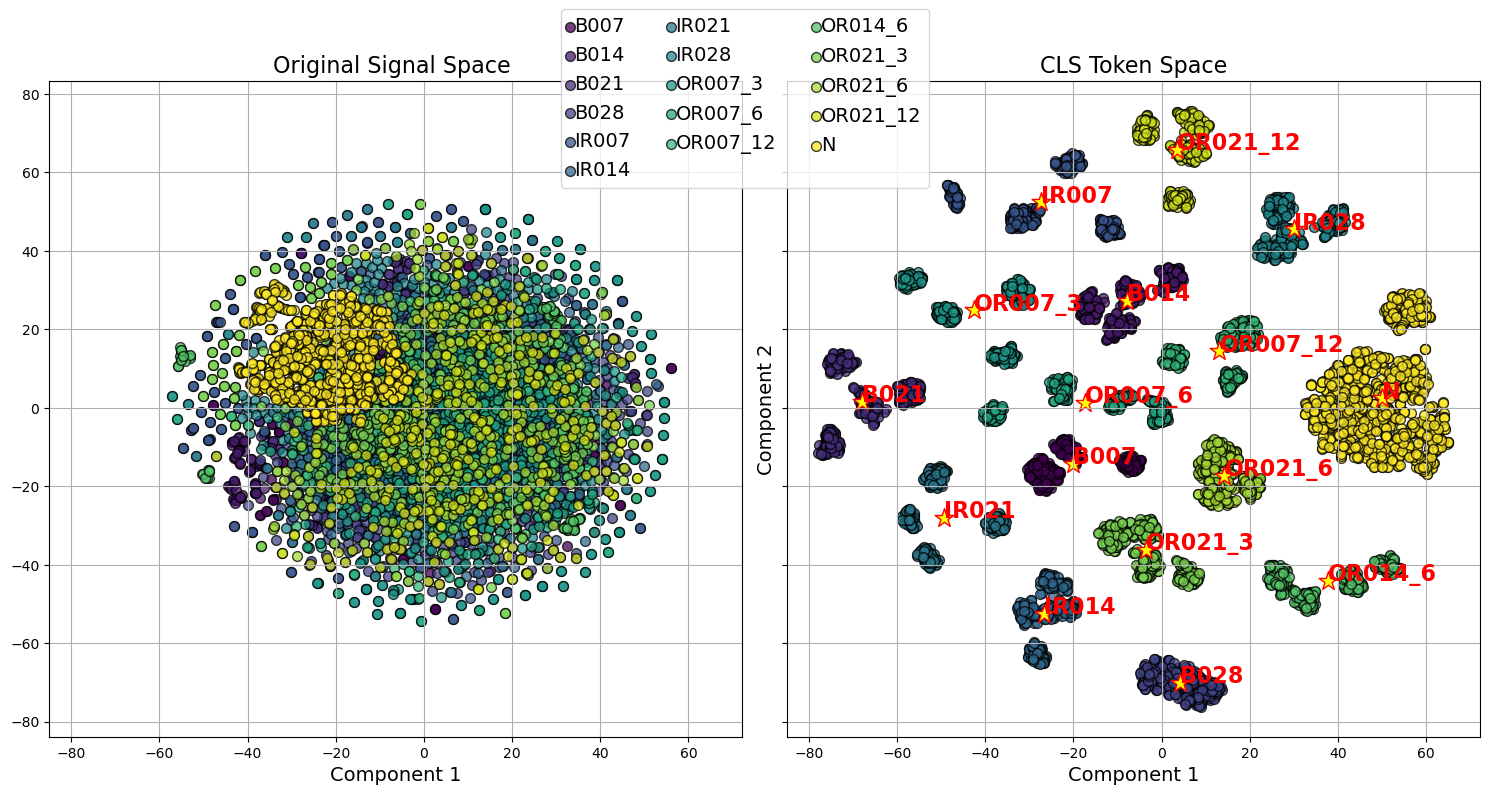

In [26]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Setup for example
# Assuming X_2d, orin_x_2d, y, labels_dict, and labels_dict_inv are defined
colors = plt.cm.viridis(np.linspace(0, 1, len(labels_dict)))

# Initialize the plot with two subplots, sharing a single legend
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

# First subplot
for label, color in zip(labels_dict.values(), colors):
    indices = y == label
    axes[1].scatter(X_2d[indices, 0], X_2d[indices, 1], c=[color], label=labels_dict_inv[label], 
                    edgecolor='k', s=50, alpha=0.75)
    # 计算每个类别的中心坐标
    mean_x = np.mean(X_2d[indices, 0])
    mean_y = np.mean(X_2d[indices, 1])
    # 在类别中心添加显眼的点
    axes[1].scatter(mean_x, mean_y, c='yellow', edgecolor='red', s=200, alpha=1, marker='*')
    # 可选：在中心点旁边添加文本标签
    axes[1].text(mean_x, mean_y, labels_dict_inv[label], fontsize=16, fontweight='bold', color='r')
    
    # axes[1].text(Fault_Tokens_2d[label, 0], Fault_Tokens_2d[label, 1], labels_dict_inv[label], fontsize=16, fontweight='bold', color='r')
axes[1].set_title('CLS Token Space', fontsize=16)
axes[1].set_xlabel('Component 1', fontsize=14)
axes[1].set_ylabel('Component 2', fontsize=14)
axes[1].grid(True)

# Second subplot
for label, color in zip(labels_dict.values(), colors):
    indices = y == label
    axes[0].scatter(orin_x_2d[indices, 0], orin_x_2d[indices, 1], c=[color], label=labels_dict_inv[label], 
                    edgecolor='k', s=50, alpha=0.75)
axes[0].set_title('Original Signal Space ', fontsize=16)
axes[0].set_xlabel('Component 1', fontsize=14)
axes[0].grid(True)

# Add a single legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize='14', ncol=len(labels_dict)//5,handletextpad=0.2, handlelength=0.1)

# Adjust layout to not overlap and to give space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the legend at the top
plt.show()


In [ ]:
fig.legend(handles, labels, loc='upper center', fontsize='14', ncol=len(labels_dict)//5, handletextpad=0.5, labelspacing=0.2)